In [609]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle as pkl
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Draw, FunctionalGroups
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt # g/mol

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## MY OWN IMPORTED MODULES
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler

from rdkit.Chem.Fragments import fr_Al_OH, fr_benzene
from rdkit.Chem.Fragments import fr_ether,fr_ArN,fr_Ar_COO,fr_Ar_N, fr_Ar_NH,fr_Ar_OH
from rdkit.Chem.Fragments import fr_NH0, fr_NH1,fr_NH2, fr_COO,fr_COO2,fr_Al_COO,fr_ester, fr_amide
# ether, aromatics (5 different), amines (3), carboxylic acid (3), ester, amide
import warnings
warnings.filterwarnings('ignore')

# Data Processing

In [610]:
df = pd.read_excel('polymer_permeability_train.xlsx')

# Split name and strings into gas-specific datasets
He_data = df.loc[:,["Polymer", "SMILES", "He","Temp(C)"]]
H2_data = df.loc[:,["Polymer", "SMILES", "H2","Temp(C)"]]
CO2_data = df.loc[:,["Polymer", "SMILES", "CO2","Temp(C)"]]
O2_data = df.loc[:,["Polymer", "SMILES", "O2","Temp(C)"]]
N2_data = df.loc[:,["Polymer", "SMILES", "N2","Temp(C)"]]
CH4_data = df.loc[:,["Polymer", "SMILES", "CH4","Temp(C)"]]

def clean_df(df):
    df = df.dropna() #gets rid of NaN (not a number) entries in the dataframes
    df = df.reset_index(drop=True)

    # Drop duplicate SMILES rows (repeated entries from separate papers)
    df = df.drop_duplicates(subset = ["SMILES"])

    return df

He_data = clean_df(He_data)      # 309 SMILES, 2048 1s and 0s each SMILE , 308 if include T
H2_data = clean_df(H2_data)      # 329 324 
CO2_data = clean_df(CO2_data)    # 479 466
O2_data = clean_df(O2_data)      # 526 513
N2_data = clean_df(N2_data)      # 520 507
CH4_data = clean_df(CH4_data)    # 415 405
#print(len(He_data),len(H2_data),len(CO2_data),len(O2_data),len(N2_data),len(CH4_data))

# EVERY 'SMILES' WILL HAVE 2048 characters of 1 and 0
def calculate_fingerprint(mol):
    fps = []
    arr = np.zeros((1,))
    fp_temp = Chem.RDKFingerprint(mol, minSize=128)
    DataStructs.ConvertToNumpyArray(fp_temp, arr)
    fps.append(arr)
    return fps

def stacking_fp(data):
    # Start array with the 0th (first) molecule in the dataframe
    mol_init = Chem.MolFromSmiles(data.iloc[0,1])
    fp = calculate_fingerprint(mol_init)
    # will remain the first row of the entire fp array
    
    # Create database of fingerprints by stacking subsequent fingerprints
    for i in range(1, len(data)):
        try:
            mol_temp = Chem.MolFromSmiles(data.iloc[i,1])
            fp_temp = calculate_fingerprint(mol_temp)
        except:
            print("Error getting fingerprint")
        fp = np.vstack([fp, fp_temp])
    return fp

def molecular_weight(data):
    mol_init = Chem.MolFromSmiles(data.iloc[0,1])
    mw = ExactMolWt(mol_init)
        
    for i in range(1, len(data)):
        try:
            mol_temp = Chem.MolFromSmiles(data.iloc[i,1])
            mw_temp = ExactMolWt(mol_temp)
        except:
            print("Error getting molecular weight")
        mw = np.vstack([mw, mw_temp])
    return mw

# Fingerprint, Molecular Weight, and Temperature as Features (X)
# Permeability (Y)

In [611]:
dataHe = He_data.copy(deep=True)
dataH2 = H2_data.copy(deep=True)
dataCO2 = CO2_data.copy(deep=True)
dataO2 = O2_data.copy(deep=True)
dataN2 = N2_data.copy(deep=True)
dataCH4 = CH4_data.copy(deep=True)

# FINGPERPRINT
He_fp = stacking_fp(dataHe)  
H2_fp = stacking_fp(dataH2)
CO2_fp = stacking_fp(dataCO2)
O2_fp = stacking_fp(dataO2)
N2_fp = stacking_fp(dataN2)
CH4_fp = stacking_fp(dataCH4)

# MOLECULAR WEIGHT
He_mw = molecular_weight(dataHe)
H2_mw = molecular_weight(dataH2)
CO2_mw = molecular_weight(dataCO2)
O2_mw = molecular_weight(dataO2)
N2_mw = molecular_weight(dataN2)
CH4_mw = molecular_weight(dataCH4)

# TEMPERATURE
tempHe = np.array([dataHe["Temp(C)"]]).T
tempH2 = np.array([dataH2["Temp(C)"]]).T
tempCO2 = np.array([dataCO2["Temp(C)"]]).T
tempO2 = np.array([dataO2["Temp(C)"]]).T
tempN2 = np.array([dataN2["Temp(C)"]]).T
tempCH4 = np.array([dataCH4["Temp(C)"]]).T

# PERMEABILITY
# All permeability datas converted to 10^x
permHe = np.log10(dataHe['He'])      # R2 train: 0.958, R2 test: 0.693 these are for randomforestregressor method
permH2 = np.log10(dataH2['H2'])      # 0.960, 0.726
permCO2 = np.log10(dataCO2['CO2'])   # 0.952, 0.691
permO2 = np.log10(dataO2['O2'])      # 0.954, 0.701
permN2 = np.log10(dataN2['N2'])      # 0.958, 0.709
permCH4 = np.log10(dataCH4['CH4'])   # 0.973, 0.634

# Putting everything into arrays of fp, mw, temp, perm
fp_array = [He_fp, H2_fp, CO2_fp, O2_fp, N2_fp, CH4_fp]
mw_array = [He_mw, H2_mw, CO2_mw, O2_mw, N2_mw, CH4_mw]
temp_array = [tempHe, tempH2, tempCO2, tempO2, tempN2, tempCH4]
perm_array = [permHe, permH2, permCO2, permO2, permN2, permCH4]
name_array = ["He", "H2", "CO2", "O2", "N2", "CH4"]

# Creating DataFrame for X and Y

# Gradient Boosting Regressor Technique

Hyperparameter Tuning as chosen:

$\bf{Bayesian\ Optimization}$: Bayesian optimization is a probabilistic model-based optimization technique that models the unknown function (e.g., the model's performance) using a probabilistic surrogate model, and uses an acquisition function to decide which hyperparameter values to sample next based on the surrogate model. Bayesian optimization is more efficient than grid search and random search in terms of the number of iterations required to find the optimal hyperparameter values.

In [655]:
# # MAKE SURE ORIGINAL DATA ARE IN ARRAY FORM

# numberfold = 5
# iteration = 10 # 10 is slow enough if fp treated individually

# ## Finding the optimum hyperparameters to be used for all six gases data
# n_estimators = np.zeros(6)
# learning_rate = np.zeros(6)
# max_depth = np.zeros(6)

# param_dist = {'n_estimators': (50, 200),'learning_rate': (0.01, 0.2, 'log-uniform'),'max_depth': (3, 5)}

# for i, xdata in enumerate(fp_array):
#     fp_data = fp_array[i]
#     mw_data = mw_array[i]
#     temp_data = temp_array[i]
#     perm_data = np.array([perm_array[i]])

#     # Create separate pandas DataFrames for the molecular weight and temperature data
#     df_mw = pd.DataFrame({'Molecular Weight': mw_data.flatten()}) 
#     df_temp = pd.DataFrame({'Temperature': temp_data.flatten()})  
#     df_perm = pd.DataFrame({'Permeability': perm_data.flatten()})

#     reshaped_data = np.reshape(fp_data, (len(fp_data), 1, 2048))
#     df_fingerprint = pd.DataFrame(reshaped_data.reshape(len(fp_data), 2048), 
#                                   columns=["Fingerprint {}".format(i+1) for i in range(2048)])

#     df_gas = pd.concat([df_fingerprint, df_mw, df_temp], axis=1)  

#     y = df_perm
#     X = df_gas

#     # Instantiate the GradientBoostingRegressor model
#     gbm = GradientBoostingRegressor()

#     # Perform Bayesian optimization
#     bayes_search = BayesSearchCV(gbm, param_dist, n_iter=iteration, cv=numberfold)

#     bayes_search.fit(X, y)

#     # Best hyperparameters found
#     best_params = bayes_search.best_params_

#     n_estimators[i] = best_params['n_estimators']
#     learning_rate[i] = best_params['learning_rate']
#     max_depth[i] = best_params['max_depth']

Running the codes above will need some time.
Numbers below are found from the code above, so just use the ones below.

In [809]:
# # Found with cv = 5 and iter = 10
n_estimators = [97., 180., 157., 180., 103., 158.]
learning_rate = [0.11351793, 0.05803862, 0.08128972, 0.16316363, 0.06052383, 0.08404079]
max_depth = [5., 4., 3., 4., 4., 3.]

# Ranking Feature Importances

In [810]:
## Feature Scores
fp_scores = np.zeros(6)
mw_scores = np.zeros(6)
temp_scores = np.zeros(6)
total_scores = np.zeros(6)

df_featurescores = pd.DataFrame(columns=['Fingerprint', 'Molecular Weight', 'Temperature'])#, 'Total Scores'])

for i, xdata in enumerate(fp_array):
    fp_data = fp_array[i]
    mw_data = mw_array[i]
    temp_data = temp_array[i]
    perm_data = np.array([perm_array[i]])

    # Concatenate elements of each row to form a list of length 2048
    fingerprint_list = [list(row) for row in fp_data]

    # Create new dataframe with single column named "fingerprint"
    df_fingerprint = pd.DataFrame({"Fingerprint": fingerprint_list}) # 308 x 1 now

    # Create separate pandas DataFrames for the molecular weight and temperature data
    df_mw = pd.DataFrame({'Molecular Weight': mw_data.flatten()}) # 308,1
    df_temp = pd.DataFrame({'Temperature': temp_data.flatten()})  # 308,1
    df_perm = pd.DataFrame({'Permeability': perm_data.flatten()})

    # Concatenate the molecular weight and temperature data into a single DataFrame
    df_gas = pd.concat([df_fingerprint, df_mw, df_temp, df_perm], axis=1)  # 308 x 2

    y = df_gas['Permeability']
    X = df_gas[['Fingerprint','Molecular Weight','Temperature']]

    # define a function to convert the list of 2048 numbers in 'fingerprint' to a single feature
    def fingerprint_to_feature(row):
        return sum(row['Fingerprint'])

    # apply the function to create a new 'fingerprint_feature' column
    X['Fingerprint'] = X.apply(fingerprint_to_feature, axis=1)

    # create a new feature matrix with only the three features
    X_new = X[['Fingerprint', 'Molecular Weight', 'Temperature']]

    # standardize the feature matrix
    scaler = StandardScaler()
    X_new = scaler.fit_transform(X_new)

    # fit a GradientBoostingRegressor to the data
    gb_reg = GradientBoostingRegressor(n_estimators = int(n_estimators[i]), learning_rate = learning_rate[i],
                                       max_depth = int(max_depth[i]), random_state = 0)
    gb_reg.fit(X_new, y)

    # get the feature importances and combine the scores for fingerprint
    importances = gb_reg.feature_importances_
    
    fp_scores[i] = importances[0]
    mw_scores[i] = importances[1]
    temp_scores[i] = importances[2]
    total_scores[i] = sum(importances)
    
    row = {'Fingerprint': fp_scores[i], 'Molecular Weight': mw_scores[i], 'Temperature': temp_scores[i]}#,
           #'Total Scores': total_scores[i]}
    df_featurescores.loc[i] = row

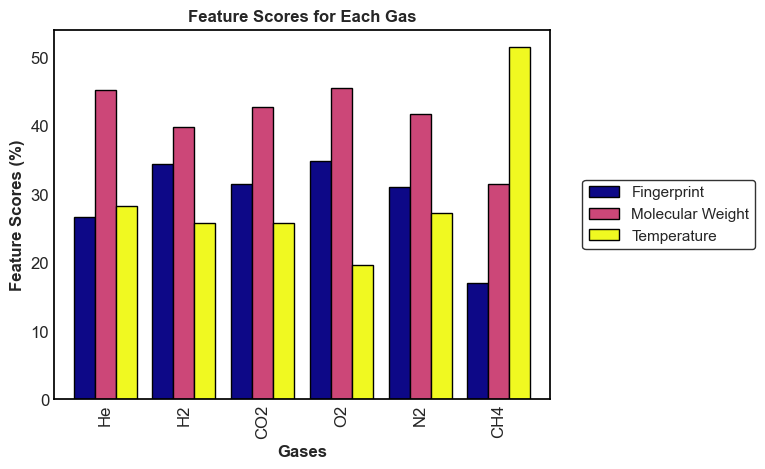

In [811]:
df_featurescores.index = name_array
df_featurescores.index.name = 'Gases'
df_features = df_featurescores.round(4)*100 # turn into percentage

# Set up the plot
fig, ax = plt.subplots(facecolor = 'none')

# Create the bar plot
df_features.plot.bar(ax=ax, width=0.8, cmap='plasma', edgecolor = 'black')

# Customize the plot
ax.set_xlabel('Gases',fontweight = 'bold')
ax.set_ylabel('Feature Scores (%)',fontweight = 'bold')
ax.set_title('Feature Scores for Each Gas',fontweight = 'bold')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

# Enable tick marks
ax.tick_params(axis='both', which='both', length=6, width=2, direction='in', labelsize=12)

# Retrieve the legend object and set the background color to white
legend = ax.get_legend()

# Set the outline color of the legend box to black
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('white')

ax.set_facecolor('white') 
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set the outline color to black
    
# Show the plot
plt.show()

# Finding Testing SCORES (MSE, MAE, and R2 values)

In [720]:
## do cross validation X SHOULD BE ALL THINGS
mae_gas = np.zeros(6)
mse_gas = np.zeros(6)
r2_gas = np.zeros(6)

mae_gas_std = np.zeros(6)
mse_gas_std = np.zeros(6)
r2_gas_std = np.zeros(6)

df_testingscores = pd.DataFrame(columns=['MAE', 'MSE', 'R^2','MAE std','MSE std','R^2 std'])

for i, xdata in enumerate(fp_array):
    fp_data = fp_array[i]
    mw_data = mw_array[i]
    temp_data = temp_array[i]
    perm_data = np.array([perm_array[i]])

    # Create separate pandas DataFrames for the molecular weight and temperature data
    df_mw = pd.DataFrame({'Molecular Weight': mw_data.flatten()}) 
    df_temp = pd.DataFrame({'Temperature': temp_data.flatten()})  
    df_perm = pd.DataFrame({'Permeability': perm_data.flatten()})

    reshaped_data = np.reshape(fp_data, (len(fp_data), 1, 2048))
    df_fingerprint = pd.DataFrame(reshaped_data.reshape(len(fp_data), 2048), 
                                  columns=["Fingerprint {}".format(i+1) for i in range(2048)])
    df_gas = pd.concat([df_fingerprint, df_mw, df_temp], axis=1)  

    y = df_perm
    X = df_gas

    # Use cross_val_score() function to perform cross-validation with multiple scoring functions
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    gb_reg = GradientBoostingRegressor(n_estimators = int(n_estimators[i]), learning_rate = learning_rate[i],
                                       max_depth = int(max_depth[i]), random_state = 0)
    gb_reg.fit(X, y)
    cv_scores = cross_validate(gb_reg, X, y, cv = numberfold, scoring=scoring)

    # Extract the mean and standard deviation for each scoring function
    mae_scores = -1 * cv_scores['test_neg_mean_absolute_error']
    mae_mean = mae_scores.mean()
    mae_std = mae_scores.std()

    mse_scores = -1 * cv_scores['test_neg_mean_squared_error']
    mse_mean = mse_scores.mean()
    mse_std = mse_scores.std()

    r2_scores = cv_scores['test_r2']
    r2_mean = r2_scores.mean()
    r2_std = r2_scores.std()
    
    mae_gas[i] = mae_mean
    mse_gas[i] = mse_mean
    r2_gas[i] = r2_mean
    mae_gas_std[i] = mae_std
    mse_gas_std[i] = mse_std
    r2_gas_std[i] = r2_std
    
    row = {'MAE': mae_gas[i], 'MSE': mse_gas[i], 'R^2': r2_gas[i], 
           'MAE std': mae_gas_std[i],'MSE std': mse_gas_std[i], 'R^2 std': r2_gas_std[i]}
    df_testingscores.loc[i] = row

In [721]:
df_testingscores.index = name_array
df_testingscores.index.name = 'Gases'
df_testing = df_testingscores.round(4)
df_testing

,MAE,MSE,R^2,MAE std,MSE std,R^2 std
Gases,,,,,,
He,0.3274,0.2320,0.7340,0.0623,0.0948,0.0953
H2,0.3631,0.2925,0.7361,0.0755,0.1202,0.1257
CO2,0.4885,0.5305,0.6741,0.0657,0.1690,0.0858
O2,0.4610,0.4867,0.7089,0.0848,0.1693,0.0825
N2,0.5150,0.5783,0.7147,0.0759,0.1895,0.0803
CH4,0.5179,0.5750,0.7462,0.0770,0.1476,0.0616


# Comparison in errors
- if no hyperparameter tuning (default: n_estimators = 100, learning_rate = 0.1, max_depth = 3)
- if no features importances (only the fingerprint)
- if don't do cross validation (80% training data, 20% testing)

In [817]:
mae_def = np.zeros(6)
mse_def = np.zeros(6)
r2_def = np.zeros(6)

df_testingscores_def = pd.DataFrame(columns=['MAE', 'MSE', 'R^2'])

for i, xdata in enumerate(fp_array):
    fp_data = xdata
    perm_data = perm_array[i]

    y = perm_data
    X = fp_data
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
    
    # Instantiate the GradientBoostingRegressor model
    gbm = GradientBoostingRegressor(random_state=0)

    # Fit the model to the training data
    gbm.fit(X_train, y_train)

    # Make predictions on new data
    y_pred = gbm.predict(X_test)
    
    mae_def[i] = mean_absolute_error(y_test, y_pred)
    mse_def[i] = mean_squared_error(y_test, y_pred)
    r2_def[i] = gbm.score(X_test, y_test)
    
    row = {'MAE': mae_def[i], 'MSE': mse_def[i], 'R^2': r2_def[i]}
    df_testingscores_def.loc[i] = row

In [819]:
df_testingscores_def.index = name_array
df_testingscores_def.index.name = 'Gases'
df_def = df_testingscores_def.round(4)
df_def

,MAE,MSE,R^2
Gases,,,
He,0.4475,0.3811,0.6521
H2,0.3730,0.2902,0.6209
CO2,0.6010,0.8580,0.5699
O2,0.4648,0.4467,0.7068
N2,0.6443,0.9134,0.6343
CH4,0.5241,0.6718,0.6750
